<a href="https://colab.research.google.com/github/icesuaraara/Python_ML_PM2.5/blob/main/ML_PM2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras.layers import Flatten, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
import numpy as np
import pandas
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/ML/dataset.xlsx'
data = pd.read_excel(path)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149351 entries, 0 to 149350
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      149351 non-null  object 
 1   location  149351 non-null  object 
 2   pm25      128451 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.4+ MB


In [ ]:
data

,date,location,pm25
0,2011-01-01,54T,NaN
1,2011-01-01,36T,NaN
2,2011-01-01,30T,NaN
3,2011-01-02,54T,NaN
4,2011-01-02,36T,NaN
...,...,...,...
149346,2022-12-30,63T,NaN
149347,2022-12-30,78T,11.0
149348,2022-12-30,80T,27.0
149349,2022-12-30,89T,22.0


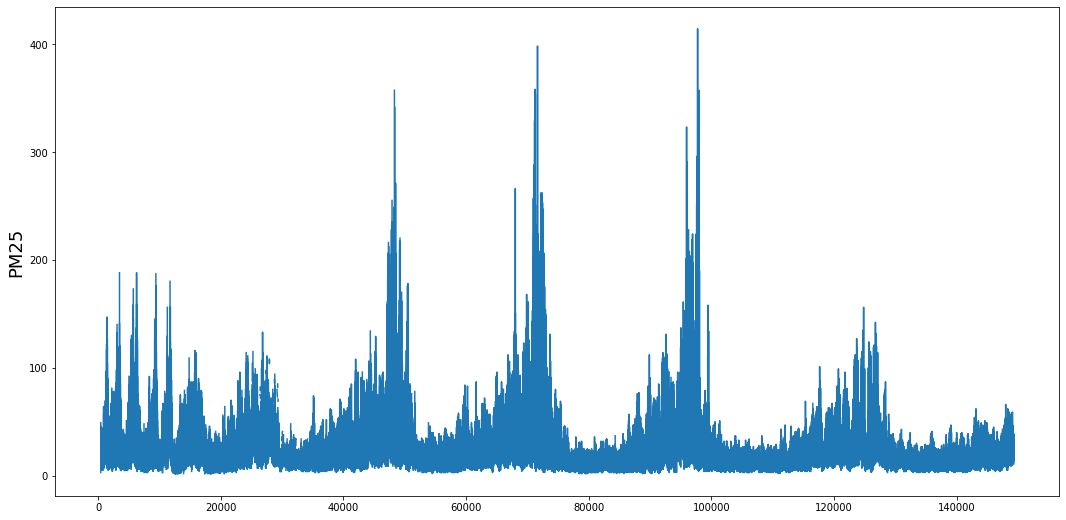

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(data['pm25'])
plt.ylabel('PM25',fontsize=18)
plt.show()

In [ ]:
datasets = []
dataset = data
dataset = dataset.dropna()
dataset['date'] = pd.to_datetime(dataset['date'])
for index, item in dataset.iterrows():
  if len(datasets) == 0:
    datasets.append({"key": item['location'].strip(), "data": [[float(item['pm25'])]], 'date': [item['date']]})
  else:
    status = False
    for key in datasets:
      if item['location'].strip() == key['key'].strip():
        key['data'].append([item['pm25']])
        key['date'].append(item['date'])
        status = True
        break
    if status == False:
      datasets.append({"key": item['location'].strip(), "data": [[float(item['pm25'])]], "date": [item['date']] })

<ipython-input-507-1dc4a0eea2fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['date'] = pd.to_datetime(dataset['date'])


In [ ]:
for item in datasets:
  if len(item['data']) < 150:
    datasets.remove(item)

In [ ]:
for item in datasets:
  scaler = MinMaxScaler(feature_range=(-1,1))
  item['data'] = scaler.fit_transform(item['data'])

In [ ]:
len(datasets)

87

In [ ]:
total_data = 0
for item in datasets:
  total_data += len(item['data'])
print(total_data)

128388


In [ ]:
for item in datasets:
    item['data'] = pd.DataFrame(item['data'], columns=["pm25"])
    item['date'] = pd.DataFrame(item['date'], columns=['date'])

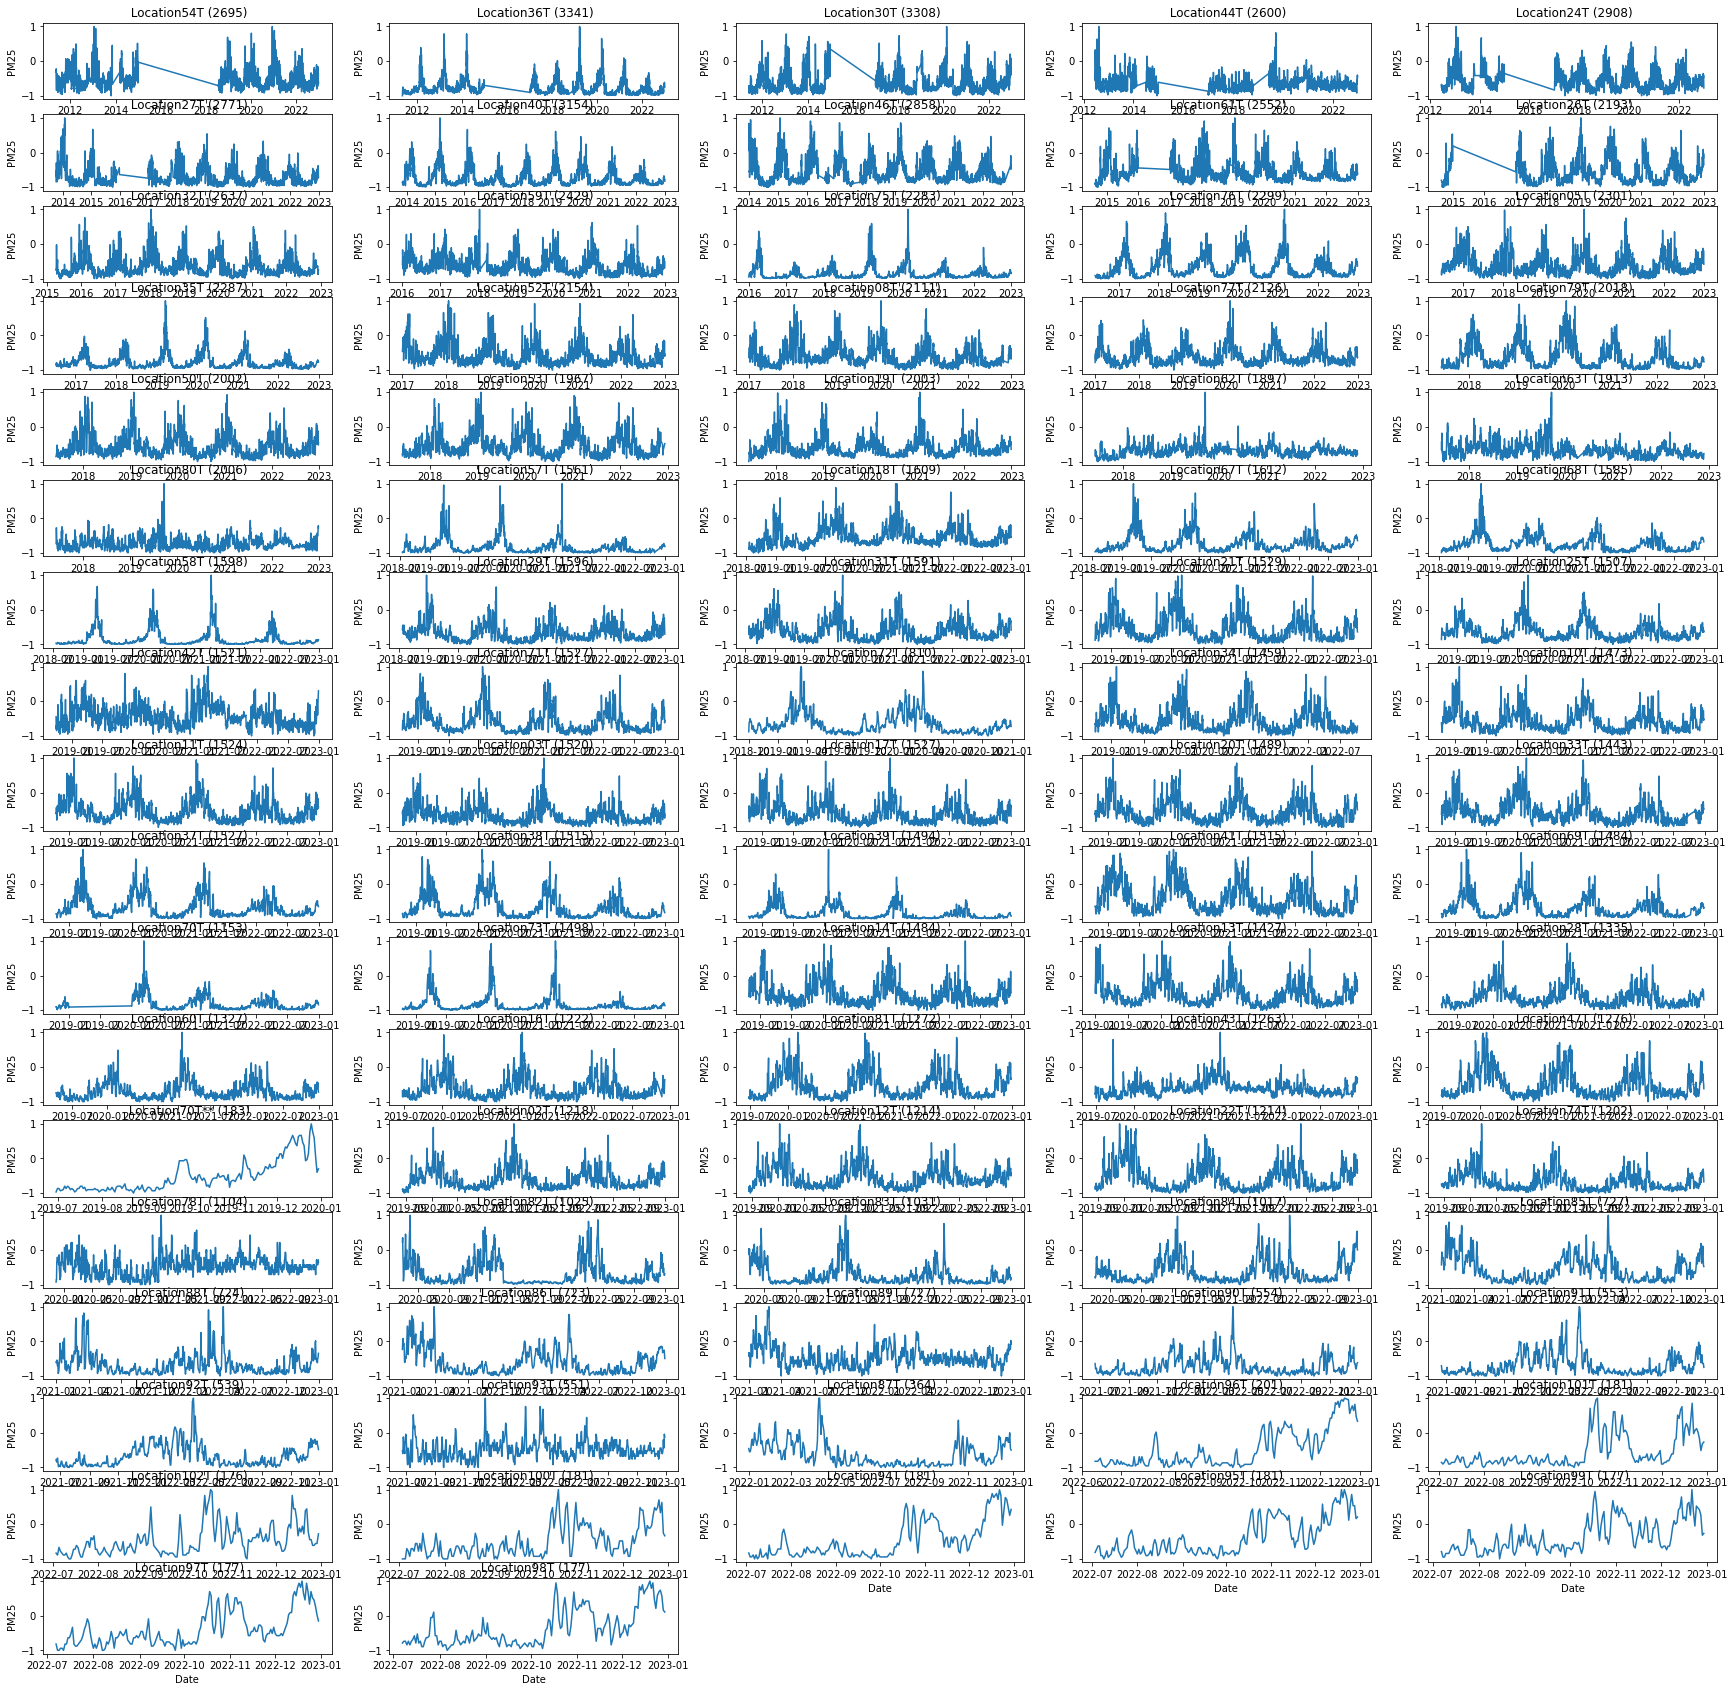

In [ ]:
# ตัวอย่าง DataSet ตำแหน่ง Location ที่ 54T
i = 1
plt.figure(figsize=(30, 30))
for item in datasets:
  plt.subplot(18, 5, i)
  plt.title(" Location" +  item['key'] + " (" + str(len(item['data'])) +")")
  plt.plot(item['date']['date'], item['data']['pm25'])
  plt.xlabel("Date")
  plt.ylabel("PM25")
  i += 1
plt.show()

In [ ]:
models = []
for item in datasets:
  df1 = item['data'].values
  values = df1
  n_train_percent = 0.85
  split = int(values.shape[0]*0.85)
  train = values[:split, :]
  test = values[split:, :]

  # เก็บค่า datetime ของ train & test
  date_reframed = item['date'].values
  date_train = date_reframed[:split]
  date_test = date_reframed[split:]

  # split feature และ target
  train_X, train_y = train[:, :-3], train[:, -3:]
  test_X, test_y = test[:, :-3], test[:, -3:]

  # reshape input ให้เป็น 3D (samples, timesteps, features)
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  # สร้าง hidden layer ตามขนาด output หรือ จำนวนวันที่ต้องการ forecast (3)
  model.add(Dense(3))
  model.compile(loss='mae', optimizer='adam')

  history = model.fit(train_X, train_y, epochs=150, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  models.append({"history": history, "model": model, 'test_X': test_X, 'test_y': test_y, 'date_test': date_test, 'key': item['key']})

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
85/85 - 0s - loss: 0.1425 - val_loss: 0.0346 - 301ms/epoch - 4ms/step
Epoch 31/150
85/85 - 0s - loss: 0.1424 - val_loss: 0.0347 - 301ms/epoch - 4ms/step
Epoch 32/150
85/85 - 0s - loss: 0.1425 - val_loss: 0.0346 - 298ms/epoch - 4ms/step
Epoch 33/150
85/85 - 0s - loss: 0.1424 - val_loss: 0.0347 - 246ms/epoch - 3ms/step
Epoch 34/150
85/85 - 0s - loss: 0.1425 - val_loss: 0.0346 - 315ms/epoch - 4ms/step
Epoch 35/150
85/85 - 0s - loss: 0.1424 - val_loss: 0.0347 - 289ms/epoch - 3ms/step
Epoch 36/150
85/85 - 0s - loss: 0.1424 - val_loss: 0.0347 - 251ms/epoch - 3ms/step
Epoch 37/150
85/85 - 0s - loss: 0.1424 - val_loss: 0.0347 - 251ms/epoch - 3ms/step
Epoch 38/150
85/85 - 0s - loss: 0.1424 - val_loss: 0.0345 - 275ms/epoch - 3ms/step
Epoch 39/150
85/85 - 0s - loss: 0.1423 - val_loss: 0.0346 - 321ms/epoch - 4ms/step
Epoch 40/150
85/85 - 0s - loss: 0.1423 - val_loss: 0.0348 - 250ms/epoch - 3ms/step
Epoch 41/150
85/85 - 0s - loss: 0.1424 - va

In [ ]:
i = 1
plt.figure(figsize=(30, 30))
for item in models:
  test_history = item
  plt.subplot(18, 5, i)
  plt.title(" Location " +  item['key'])
  plt.plot(test_history['history'].history['loss'], label='train')
  plt.plot(test_history['history'].history['val_loss'], label='test')
  plt.legend()
  i += 1
plt.show()

In [ ]:
i = 1
plt.figure(figsize=(30, 30))
for item in models:
  test_history = item
  plt.subplot(18, 5, i)

  plt.title(" Location " +  item['key'])
  test_X = test_history['test_X']
  test_y = test_history['test_y']
  yhat = model.predict(test_X)
  date_test = test_history['date_test']
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


  inv_yhat = scaler.inverse_transform(yhat)
  inv_y = scaler.inverse_transform(test_y)


  idx = np.random.randint(0,len(yhat-3))
  if idx <30:
    date_actual = date_test[:idx+3]
  else:
    date_actual = date_test[idx-30:idx+3]
    plt.plot(date_actual,inv_y[max(0,idx-30):idx+3,0],'b')
    plt.plot(date_test[idx:idx+3],inv_yhat[idx],'r')
    plt.xlabel("Date")
    plt.ylabel("PM25")
  i += 1